In [1]:
import math
import jax
from jax import grad
import jax.numpy as jnp
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
from solve_bvp import StabilityEvalEnv

## I want to create a direct pipeline for solving the boundary value problem and computing the loss for a given an active stress profile

All I need to do is solve the following differential equation

\begin{equation}
B\frac{d^2\theta}{ds^2} + \frac{dm^a}{ds} - \rho g s cos\theta = 0
\end{equation}

with 
\begin{equation}
\theta(0) = 0 \\
\theta(l) = 0 \\
\frac{d\theta}{ds}(0) + m^a(0) = 0
\end{equation}

So we have a second order ODE but we have three boundary conditions. The third boundary condition allows us to fix $l$. Since $l$ is a parameter we are solving for we need to make it explicit in the equation and enforce the boundary conditions at known points relative to a given $l$. We do this by introducing the variable $\tilde{s} = \frac{s}{l}$ and rewriting the equations in terms of $\tilde{s}$. Now we get 

\begin{equation}
\frac{B}{l^2}\frac{d^2\theta}{d\tilde{s}^2} + \frac{1}{l}\frac{dm^a}{d\tilde{s}} - l\rho g \tilde{s} cos\theta = 0
\end{equation}

with boundary conditions in $\tilde{s}$ telling us

\begin{equation}
\theta(0) = 0 \\
\theta(1) = 0 \\
\frac{d\theta}{d\tilde{s}}(0) + lm^a(0) = 0
\end{equation}

Great.

## Turning this into a system of ODEs and solving the BVP numerically

We need to turn the above second order ODE into a system of first order ODEs. We do so by introducing the variables 
\begin{equation}
\theta_1 = \theta \\
\theta_2 = \frac{d\theta_1}{d\tilde{s}}
\end{equation}

Now the second order ODE becomes

\begin{equation}
\frac{d\theta_1}{d\tilde{s}} = \theta_2 \\ 
\frac{d\theta_2}{d\tilde{s}} = -\frac{l}{B}\frac{dm^a}{d\tilde{s}} + \frac{l^3}{B}\rho g \tilde{s}cos\theta_1
\end{equation}

Where 
\begin{equation}
\theta_1 (0) = \theta_1(1) = 0 \\
\theta_2(0) = -l m^a(0)
\end{equation}

We can use the built in boundary value problem solver in SciPy to integrate this system. In order to make sure the functions used by the boundary value problem solve have access to what they need, we will define a class which holds everything. The StabilityEvalEnv does that. Let's look at what it gives for a few sample active torque profiles.


## $m_a(\tilde{s}) = \tilde{s}^2 + 0.5$ 

In [2]:
# snake = StabilityEvalEnv(ma=lambda r: jnp.cos(2 * math.pi * r) ** 2 + 0.5, B=1)
snake = StabilityEvalEnv(ma=lambda r: jnp.square(1) / (0.1 + r ** 3) + 0.5, B=1)

In [11]:
from scipy.special import gamma


def beta_pdf(x, a=0.7, b=1.55):
    B = gamma(a) * gamma(b) / gamma(a + b)
    num = x ** (a - 1) * (1 - x) ** (b - 1)
    return num / B

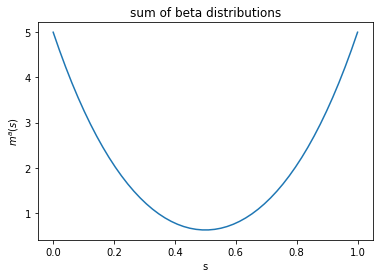

In [21]:
x = np.linspace(0, 1, 50)
plt.plot(x, beta_pdf(x, a=5, b=1) + beta_pdf(x, a=1, b=5))
plt.title("sum of beta distributions")
plt.xlabel("s")
plt.ylabel(r"$m^a(s)$")
plt.show()

In [16]:
snake = StabilityEvalEnv(
    ma=lambda r: jnp.square(1) * beta_pdf(r, a=5, b=1) + beta_pdf(r, a=1, b=5), B=1
)

Solution says l = 0.0
Cost is 0.0


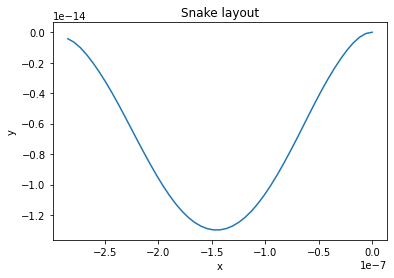

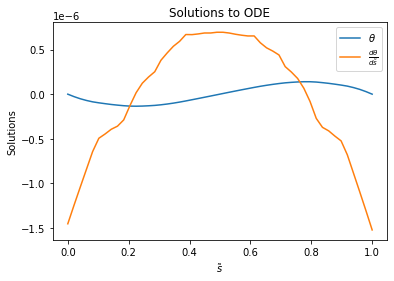

In [17]:
snake.solve()
print(f"Cost is {round(snake.get_cost(),3)}")
snake.plot_snake()
snake.plot_solutions()

In [18]:
snake.check_constraints()

False

In [15]:
snake.sol.message

'The algorithm converged to the desired accuracy.'

In [16]:
# from scipy.stats import beta